In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from numpy import mean

In [37]:
from analysis import *
# behaviour_idx = BEHAVIOUR_LABELS['Groom']

# behaviour_idx = BEHAVIOUR_LABELS['Rear (AW)']
# behaviour_idx.extend(BEHAVIOUR_LABELS['Rear'])

# behaviour_idx = BEHAVIOUR_LABELS['CW-Turn']
# behaviour_idx.extend(BEHAVIOUR_LABELS['CCW-Turn'])

behaviour_idx = BEHAVIOUR_LABELS['Run']
behaviour_idx.extend(BEHAVIOUR_LABELS['Walk'])

info = calculate_behaviour_info_for_all_strains(data_lookup_file='bsoid_strain_data.csv', min_bout_len=round(1000 * FPS / 1000), behaviour_idx=behaviour_idx)

100%|██████████| 126/126 [02:48<00:00,  1.34s/it]


In [38]:
info_ = info.copy(deep=True)
info_['Total Duration'] = info['Total Duration']/60
info_['Average Bout Length'] = info['Average Bout Length']

# plotting routines

In [16]:
def sort_info_df(info, metric):
    N = info.shape[0]
    strains = {}
    for strain in info['Strain']:
        strains[strain] = []
        
    for i in range(N):
        data = info.iloc[i]
        strains[data['Strain']].append(data[metric])
    
    for key, value in strains.items():
        strains[key] = sum(value)/len(value)
    
    strains = dict(sorted(strains.items(), key=lambda item: item[1]))
    return strains.keys()

def plot_behaviour_metric(info, metric, order, ylabel=None):        
    ylabel = metric if ylabel is None else ylabel
    
    fig = plt.figure(figsize=(10, 100))
    g = sns.catplot(x='Strain', y=metric, data=info, hue='Sex', jitter=False, legend=False, order=order, ci=0.95)
    ax = g.axes[0,0]
    ax.tick_params(grid_color='gray', grid_alpha=0.3, labelrotation=90, labelsize=8)
    ax.grid(True)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(None, fontsize=12)
    ax.legend(loc='upper left')
    plt.gcf().set_size_inches(15, 2.2)
    return fig, ax

(<Figure size 720x7200 with 0 Axes>,
 <AxesSubplot:ylabel='Total Duration (min)'>)

<Figure size 720x7200 with 0 Axes>

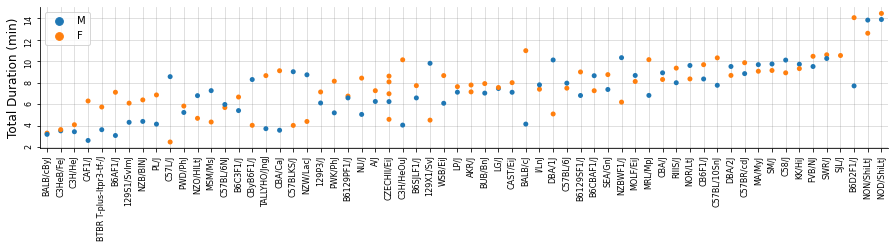

In [39]:
strains = list(sort_info_df(info_, 'Total Duration'))
plot_behaviour_metric(info_, 'Total Duration', strains, 'Total Duration (min)', )

<Figure size 720x7200 with 0 Axes>

<Figure size 720x7200 with 0 Axes>

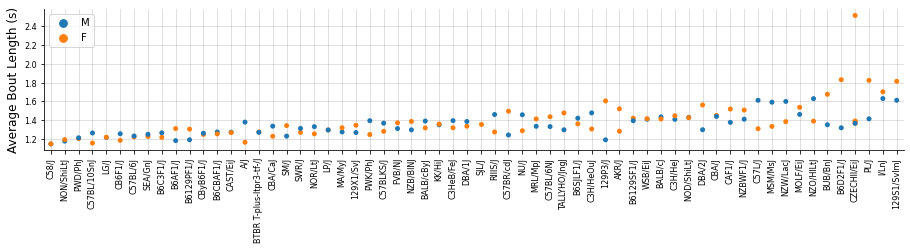

In [40]:
strains = list(sort_info_df(info_, 'Average Bout Length'))
fig, ax = plot_behaviour_metric(info_, 'Average Bout Length', strains, 'Average Bout Length (s)', )
# ax.set_ylim([1, 2])
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

<Figure size 720x7200 with 0 Axes>

<Figure size 720x7200 with 0 Axes>

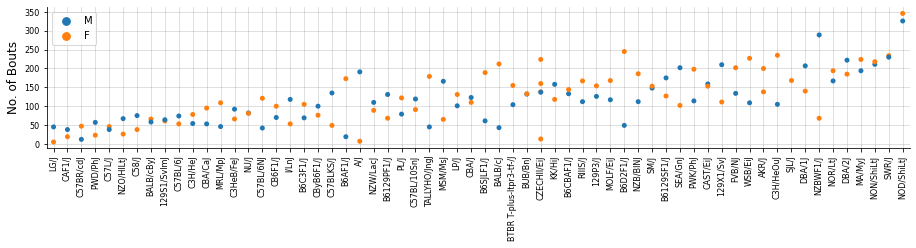

In [41]:
strains = list(sort_info_df(info_, 'No. of Bouts'))
fig, ax = plot_behaviour_metric(info_, 'No. of Bouts', strains, 'No. of Bouts', )
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

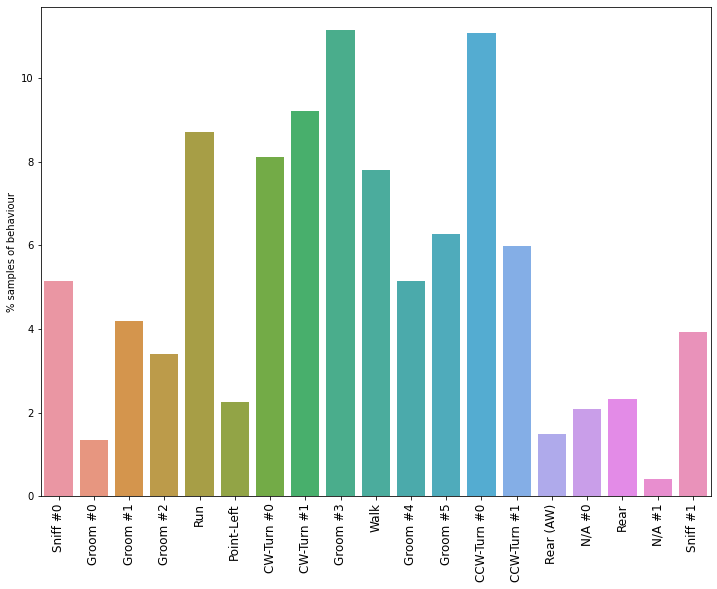

In [7]:
# plot behaviour distribution for all data
import numpy as np
from analysis import *
from BSOID.bsoid import BSOID

prop = 100 * calculate_behaviour_usage(data_lookup_file='./bsoid_strain_data.csv')

labels = [None for _ in range(len(prop))]
for key, val in BEHAVIOUR_LABELS.items():
    if len(val) > 1:
        for i, idx in enumerate(val):
            labels[idx] = f'{key} #{i}'
    else:
        labels[val[0]] = key
fig = plt.figure(figsize=(12,9))
ax = sns.barplot(x=np.arange(len(prop)), y=prop)
ax.set_xticklabels(labels)
ax.set_ylabel('% samples of behaviour')
ax.tick_params(axis='x', labelrotation=90, labelsize=12)
fig.show()

# Show proportion of behaviour used for each strain
----

100%|██████████| 126/126 [08:52<00:00,  4.23s/it]


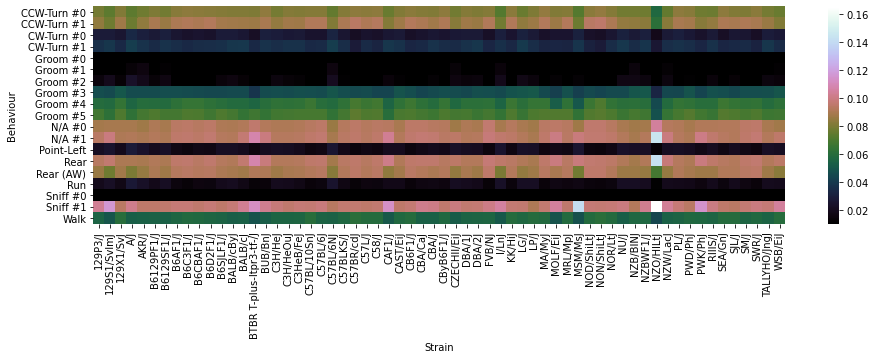

In [43]:
from analysis import *
usage_data = behaviour_usage_across_strains(data_lookup_file='./bsoid_strain_data.csv', min_thresh=0.01, min_bout_len=100)
usage_data = usage_data.pivot('Behaviour', 'Strain', 'Usage')

ax = sns.heatmap(usage_data, xticklabels=True, yticklabels=True, cmap='cubehelix')
plt.gcf().set_size_inches(15.5, 4)
plt.show() 